### Basic ECG Transformation

In [1]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

import rlign

In [2]:
normalizer = rlign.Rlign()
hrc_normalizer = rlign.Rlign(scale_method='hrc', template_bpm=80, offset=.01)
median_normalizer = rlign.Rlign(scale_method='hrc', median_beat=True, template_bpm=80, offset=.01)

In [3]:
ecg = np.expand_dims(nk.ecg_simulate(sampling_rate=500, heart_rate=50), (0, 1)).repeat(12, axis=1)
# standard ecg form: (sample x lead x time)
ecg.shape

(1, 12, 5000)

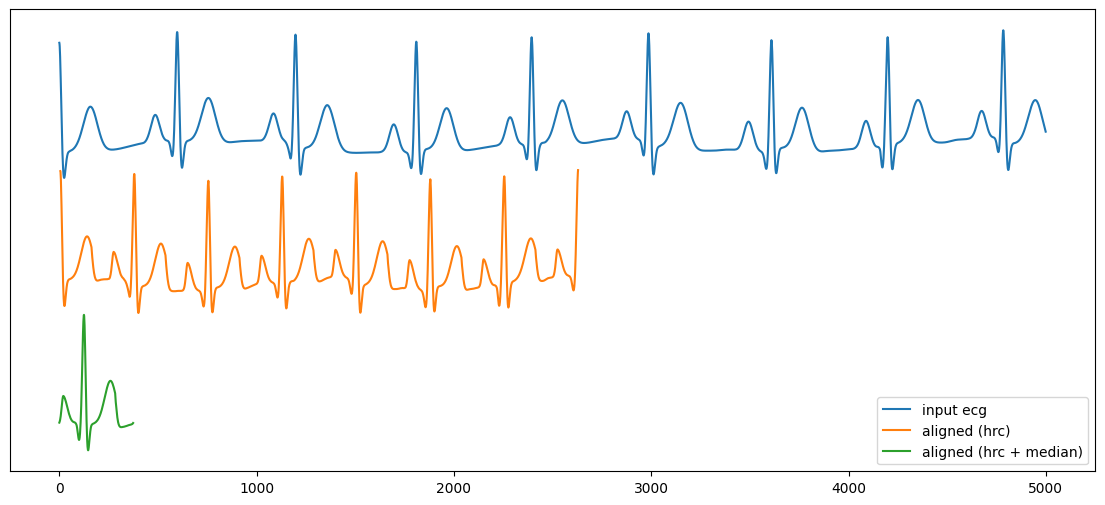

In [4]:
plt.figure(figsize=(14, 6))
channel = 1
plt.plot(ecg[0].transpose(1,0)[:, channel], label="input ecg")

ret = hrc_normalizer.transform(ecg)
ret2 = median_normalizer.transform(ecg)
plt.plot(ret[0, channel, :] - 1.5, label="aligned (hrc)")
plt.plot(ret2[0, channel, :] - 3, label="aligned (hrc + median)")
plt.yticks([])
plt.legend(loc="lower right")

## Scikit-Learn-based Classification

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

normal_ecgs = []
for i in range(30):
    normal_ecgs.append(nk.ecg_simulate(sampling_rate=500, 
                                       heart_rate=np.random.randint(40, 70)
                                       ).reshape((1,1,5000))
                       )
normal_ecgs = np.concatenate(normal_ecgs, axis=0)  
abnormal_ecgs = []
for i in range(30):
    abnormal_ecgs.append(1.1*nk.ecg_simulate(sampling_rate=500, 
                                             heart_rate=np.random.randint(40, 70)
                                             ).reshape((1,1,5000))
                         )
abnormal_ecgs = np.concatenate(abnormal_ecgs, axis=0)

In [6]:
X = np.concatenate([normal_ecgs, abnormal_ecgs], axis=0)
y = [0] * len(normal_ecgs) + [1] * len(abnormal_ecgs)

In [7]:
normalizer = rlign.Rlign(select_lead=0, template_bpm=40)

In [8]:
pipe = Pipeline([("Aligner", normalizer),
                 ("Reshaper", FunctionTransformer(lambda X: X.reshape(X.shape[0], -1))),
                 ("Imputer", SimpleImputer()),
                 ("LR", LogisticRegression(max_iter=1000))])

In [9]:
%%time

print(f"Balanced accuracy on non-aligned ECGs: {round(np.mean(cross_val_score(LogisticRegression(), X[:, 0], y)), 3)}")
print(f"Balanced accuracy on aligned ECGs: {round(np.mean(cross_val_score(pipe, X, y)), 3)}")

Balanced accuracy on non-aligned ECGs: 0.5
Balanced accuracy on aligned ECGs: 1.0
CPU times: user 204 ms, sys: 140 ms, total: 344 ms
Wall time: 7.43 s


In [10]:
%%time

pipe = Pipeline([("Reshaper", FunctionTransformer(lambda X: X.reshape(X.shape[0], -1))),
                 ("Imputer", SimpleImputer()),
                 ("LR", LogisticRegression(max_iter=1000))])

print(f"Balanced accuracy on non-aligned ECGs: {round(np.mean(cross_val_score(LogisticRegression(), X[:, 0], y)), 3)}")
Xt = normalizer.transform(X)
print(f"Balanced accuracy on aligned ECGs: {round(np.mean(cross_val_score(pipe, Xt, y)), 3)}")

Balanced accuracy on non-aligned ECGs: 0.5
Balanced accuracy on aligned ECGs: 1.0
CPU times: user 170 ms, sys: 23.5 ms, total: 194 ms
Wall time: 918 ms
